<a href="https://colab.research.google.com/github/tocram1/ExercicesIA/blob/master/Perceptron_Wildrow_Hof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chargement du jeu de données
Jeux de caractères manuscrits proposé par scikitlearn

In [ ]:
%matplotlib inline

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math

# Découpage d'un jeu de données
# par defaut 20% pour les tests et 80% pour l'apprentissage
# Le jeu de données est mélangé
def split_train_test( data, annotation, ratio=0.2, seed=42 ):
    np.random.seed(seed)
    liste = list(zip(data, annotation))
    np.random.shuffle(liste)
    data, annotation = zip(*liste)
    size_test = int( len(data) * (1-ratio) )
    return np.array(data[:size_test]), np.array(annotation[:size_test]),\
            np.array(data[size_test+1:]), np.array(annotation[size_test+1:])

# Convertion nuance de gris => noir&blanc
# Modification de chaque image du jeu de donnée
# si la nuance de gris est supérieur au seuil alors le pixel est allumé
def modif_input( dataset ):
    for n in range(len(dataset)):
        for i in range(len(dataset[n])):
             dataset[n][i] = dataset[n][i]/16
    return dataset

# Convertion des données de classification
# on ne garde qu'une classe, un élément est dans la classe ou il ne l'est pas
    
def modif_output( dataset, classe = 9 ):
    for n in range(len(dataset)):
        dataset[n] = 1 if dataset[n] == classe else -1 
    return dataset

# chargement du jeu de données et préparation des données
digits = load_digits()

trainX, trainY, testX, testY = split_train_test(digits.data, digits.target)

trainX = modif_input(trainX)
testX = modif_input(testX)

trainY = modif_output(trainY)
testY = modif_output(testY)

### Algo Apprentissage
L'apprentissage de WildrowHof se fait en réduisant l'erreur par descente de gradient.  
Le vecteur poids est modifié par passe succéssive, une passe correspond à calculer un pas de descente de gradient pour tous les carractères du jeu.  
Par defaut on fait 20 passes et en sortie on a le tableau des poids et de l'évolution de l'erreur quadratique moyenne.

In [ ]:
def initWeight( nbr ):
    # initialisation de la matrice de poids W
    W = np.mat( np.random.random(nbr + 1))
    W = 2*W - 1 # On passe d'un tirage entre [0 1] à [-1, 1]
    return W

# Apprentissage, algo Wildrow/Hof
# mu est la "vitesse" d'apprentissage
# Par defaut, valeur 1 pour le poids W0 (biais)
def decenteDeGradient( entrees, sorties, W, mu = 0.0001, biais = 1) :
    erreur = []
    # pour chaque vecteur du jeu de données
    for n in range(len(entrees)):
        X = np.mat(np.insert(entrees[n], 0, biais)) # Ajout du biais
        S = sorties[n]
        e = (S - X*np.transpose(W)) # forward propagation (calcul de l'erreur)
        erreur.append(e[0,0])
        W = W + 2 * mu * e * X    

    return erreur, W

def fitWildrowHof( entrees, sorties, ecart=False, max_iter=20 ):
    loss = [] # tableau pour enregistrer l'évolution du MSE
    w_vec = initWeight(len(entrees[0]))
        
    # Calcul du poid de chaque jeu par descente de gradient
    iter = 0
    erreur_vec, w1_vec = decenteDeGradient( entrees, sorties, w_vec )
    # Calcul du MSE np.square(erreur_vec).mean() ou encore sum([e*e for e in erreur_vec])/len(erreur_vec)
    loss.append( np.square(erreur_vec).mean() )

    while iter < max_iter :
        w_vec = w1_vec
        erreur_vec, w1_vec = decenteDeGradient( entrees, sorties, w_vec )
        if ecart:
            affiche_erreur( erreur_vec ) #affiche les écarts
        loss.append( np.square(erreur_vec).mean() ) # sauvegarde de l'erreur quadratique moyenne
        iter = iter+1
    
    return loss, w_vec
            
    
    

### affiche_erreur
Prend en parametre e : un tableau de réel.   
e contient pour chaque caractère l'écart entre la valeur désirée et la valeur calculée.  
La fonction affiche tous les écarts, en abcisse on a le numéro ou l'id de l'image et en ordonné l'écart

In [ ]:
def affiche_erreur(e):
    plt.figure(figsize=(10,3), dpi=300)
    plt.ylim(-5,5)
    plt.grid()
    ordonne = []
    for x in range(len(e)):
        ordonne.append(x)
    plt.plot(ordonne, e,'b')
    plt.show()

In [ ]:
loss, weights = fitWildrowHof(trainX, trainY, max_iter=100)

### Courbe de progression de l'erreur
L'erreur quadratique moyenne (MSE) est enregistrée pour chaque itération d'apprentissage. 
Le code ci-dessous affiche l'évolution de la MSE au fur et à mesure de l'apprentissage.


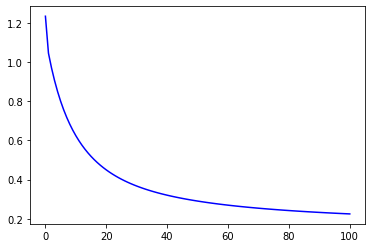

In [ ]:
ordonne = []
for x in range(len(loss)):
    ordonne.append(x)
plt.plot(ordonne, loss,'b')
plt.show()

### Prédiction
C'est un propagation vers l'avant dans le reseau.

In [ ]:
# Détermination de la classe en fonction des poids appris précédement
# Fonction d'activation Heaviside
def predictWildrowHof( entrees, W, biais = 1, seuil = 0):
    Y = []
    for X in entrees :
        X = np.mat(np.insert(X, 0, biais)) # valeur 1 pour le poids W0 (biais)
        y = X * np.transpose(W) # Calcule de la sortie
        if y[0,0] >= seuil:
            Y.append(1) # Heaviside seuil à 0 par défaut
        else:
            Y.append(-1)
    return Y

### Performance
Mise en place des indices de performance, matrice de confusion et score

In [ ]:
# Calcul de la présicion et de la sensibilité d'un model à partir de sa matrice de confusion
def matriceDeConfusion( test, predic ):
    couple = list(zip(test,predic))
    nbrCouple = Counter(couple)
    TruePositif = nbrCouple[(1,1)]
    FalsePositif = nbrCouple[(-1,1)]
    TrueNegatif = nbrCouple[(-1,-1)]
    FalseNegatif = nbrCouple[(1,-1)]
    preci = (TruePositif/(TruePositif+FalsePositif)) if ((TruePositif+FalsePositif)>0) else 0
    rappel = (TruePositif/(TruePositif+FalseNegatif)) if ((TruePositif+FalseNegatif)>0) else 0
    return preci, rappel

# Calcul du score à partir de la moyenne harmonique
def score( preci, rappel ):
    return (2/((1/preci)+(1/rappel))) if ((preci and rappel) != 0) else 0


### Evaluation
Prédiction sur le jeu de test, calcul de la prédiction et de la sensibilité

In [ ]:
prediction = predictWildrowHof( trainX, weights, seuil = 0 )
print(trainY)
print(prediction)
# Evaluation de la performance du model
preci, rappel = matriceDeConfusion( trainY, prediction )
print(" Précision du model : {:.2f}%\n Sensibilité (rappel) : {:.2f}%".format(preci*100,rappel*100))
print(" Score : {:.2f}".format(score(preci, rappel)*100))

[-1  1 -1 ... -1 -1 -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

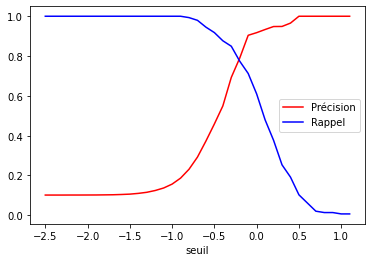

In [ ]:
# Détermination du seuil
x = []
precision_evolution = []
rappel_evolution = []
for seuil in [ x/10 for x in range(-25, 12)]:
    x.append(seuil)
    prediction = predictWildrowHof( trainX, weights, seuil=seuil)
    preci, rappel = matriceDeConfusion( trainY, prediction )
    precision_evolution.append( preci )
    rappel_evolution.append( rappel )
    
plt.plot(x, precision_evolution,"r-", label="Précision")
plt.plot(x, rappel_evolution, "b-", label="Rappel")
plt.legend()
plt.xlabel("seuil")
plt.show()

### Courbe ROC Receiver Operating Characteristic

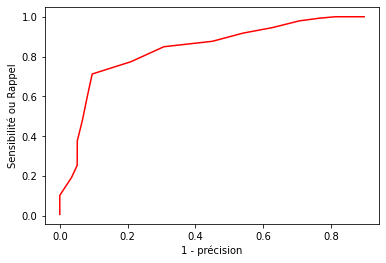

In [ ]:
plt.plot(1-np.array(precision_evolution), rappel_evolution,"r-")
plt.xlabel("1 - précision")
plt.ylabel("Sensibilité ou Rappel")
plt.show()

In [ ]:
weights.tofile("poids", ",","%s")

In [ ]:
print(weights)

[[-1.00125817  0.64902809 -0.3416085  -0.47116767  0.5180587  -0.37440006
   0.00261881  0.20796542 -0.93591189  0.33557916  0.43176415 -0.43510745
   0.1497723  -0.03389264  0.06077509  0.01517287 -0.44772942  0.86965116
   0.32370764  0.35920592  0.1937334   0.12866791  0.41362877  0.20762161
   0.07123553  0.19495173 -0.01705617  0.01885655  0.19989739  0.04845244
   0.16680512  0.18286491  0.18569424  0.30058837 -0.2936336   0.07698421
  -0.02630945 -0.22056236  0.04227055  0.36721548 -0.13268933 -0.89685535
  -0.20594005 -0.50777324  0.18298334 -0.33412008  0.21102249 -0.22454547
  -0.84345043 -0.18269736 -0.20289639  0.21563177 -0.55794219  0.03169182
  -0.48489269  0.46541061 -0.25063133  0.69249058  0.22453705  0.17125306
   0.02962949  0.00826953  0.21458077 -0.17296353  0.04601198]]
